<a href="https://colab.research.google.com/github/Lemuca09/trabalho-rede-neural/blob/main/Previs%C3%A3oA%C3%A7%C3%B5esLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [760]:
import os
import json
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from numpy.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import seaborn as sns

# from scipy.interpolate import lagrange
# from tensorflow import EarlyStopping

**Configurações**

In [761]:
TICKERS = ['AAPL', 'MSFT', 'GOOGL']
# TICKERS = ['GOOGL']
# TICKERS = ['NVDA', 'AMZN', 'META']
WINDOW_SIZE = 12  # 12 semanas (~3 meses)
EPOCHS = 300 # 300
BATCH_SIZE = 4

TRAIN = False # Controle para se for necessário retreinar

FUTURE_STEPS = 4  # número de semanas a prever

MODEL_PATH = "modelo_lstm_portfolio_acoes.h5"
HISTORY_PATH = "history_lstm.json"

**Baixar dados semanais dos últimos 3 anos**

In [762]:
dfs = []
for ticker in TICKERS:
    data = yf.Ticker(ticker).history(period="3y", interval="1wk")['Close']
    data.name = ticker
    dfs.append(data)

**Combinar e limpar**

In [763]:
df = pd.concat(dfs, axis=1)
df.dropna(inplace=True)

**Criar valor médio do portfólio**

In [764]:
df['Portfolio'] = df.mean(axis=1)
portfolio_values = df['Portfolio'].values

**Padronizar (z-score)**

In [765]:
mean = np.mean(portfolio_values)
std = np.std(portfolio_values)
portfolio_scaled = (portfolio_values - mean) / std

mean, std

(np.float64(224.03090873442895), np.float64(44.24614562516335))

**Janela deslizante**

In [766]:
X, y = [], []
for i in range(len(portfolio_scaled) - WINDOW_SIZE):
    X.append(portfolio_scaled[i:i + WINDOW_SIZE])
    y.append(portfolio_scaled[i + WINDOW_SIZE])
X = np.array(X)
y = np.array(y)

**Reshape para LSTM: (samples/batch_size, timesteps, features)**

In [767]:
X = X.reshape((X.shape[0], X.shape[1], 1)) # 101 sequências no batch, 12 Semanas, 1 Valor/Preço

**Dividir treino/teste**

In [768]:
split = int(len(X) * 0.7) # 0.8
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X[:split].shape, X[split:].shape      # 101/44 sequências, cada uma com 12 passos temporais, cada passo tem 1 feature.

((101, 12, 1), (44, 12, 1))

**Dividir treino/teste** E **Treinar**

In [769]:
if os.path.exists(MODEL_PATH) and TRAIN != True:
    print("\U0001f501 Carregando modelo salvo...")
    model = tf.keras.models.load_model(MODEL_PATH)
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(0.8), metrics=['mse','mae', 'mape'])
    with open(HISTORY_PATH, "r") as f:
        loss_data = json.load(f)
else:
    print("🔁 Treinando novo modelo...")
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='elu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(0.8), metrics=['mse','mae', 'mape'])
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        verbose=1
    )
    model.save(MODEL_PATH)
    print(f"✅ Modelo salvo em {MODEL_PATH}")

    # Salvar histórico
    with open(HISTORY_PATH, "w") as f:
        json.dump(history.history, f)
    print(f"✅ Histórico salvo em {HISTORY_PATH}")


🔁 Carregando modelo salvo...


**Prever e Inverter Padronização**

In [770]:
predictions = model.predict(X_test).flatten()
predictions_real = predictions * std + mean
y_test_real = y_test * std + mean

print(history.history['loss'][-1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
0.011634650640189648


## Visualizando o conjunto de teste (test set). O modelo foi treinado com 70% dos dados (split = int(len(X) * 0.7)), e o restante (30%) é usado para teste e plot. Isso representa cerca de:

##156 semanas ≈ **3 anos**

## 30% de 156 ≈ 47 semanas, ou seja quase **11 meses**, o que confere exatamente com o intervalo do gráfico.

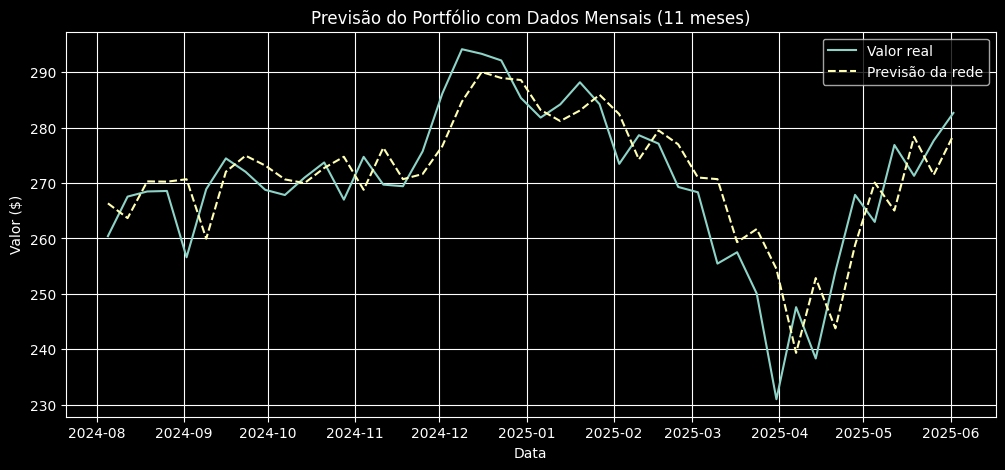

(Timestamp('2024-08-05 00:00:00-0400', tz='America/New_York'),
 Timestamp('2025-06-02 00:00:00-0400', tz='America/New_York'))

In [771]:

dates = df.index[-len(y_test_real):]  # pega as datas correspondentes ao conjunto teste

plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
plt.plot(dates, y_test_real, label='Valor real')
plt.plot(dates, predictions_real, label='Previsão da rede', linestyle='--')
plt.title('Previsão do Portfólio com Dados Mensais (11 meses)')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()

dates[0], dates[-1]


**Passos a Frente**

In [772]:
last_window = portfolio_scaled[-WINDOW_SIZE:].tolist()
future_predictions_scaled = []

for _ in range(FUTURE_STEPS):
    input_array = np.array(last_window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1) # Como o modelo usado, foi LSTM, redimensiona para o formato esperado
    next_pred = model.predict(input_array)[0, 0]
    future_predictions_scaled.append(next_pred)
    last_window.append(next_pred)

future_predictions_real = [p * std + mean for p in future_predictions_scaled] # Desnormaliza as previsões para escala original

predictions_str = ', '.join([str(p) for p in future_predictions_real])
print(np.array(predictions_str))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
281.3972218768819, 280.424198973177, 279.95956899857634, 279.58635755205273


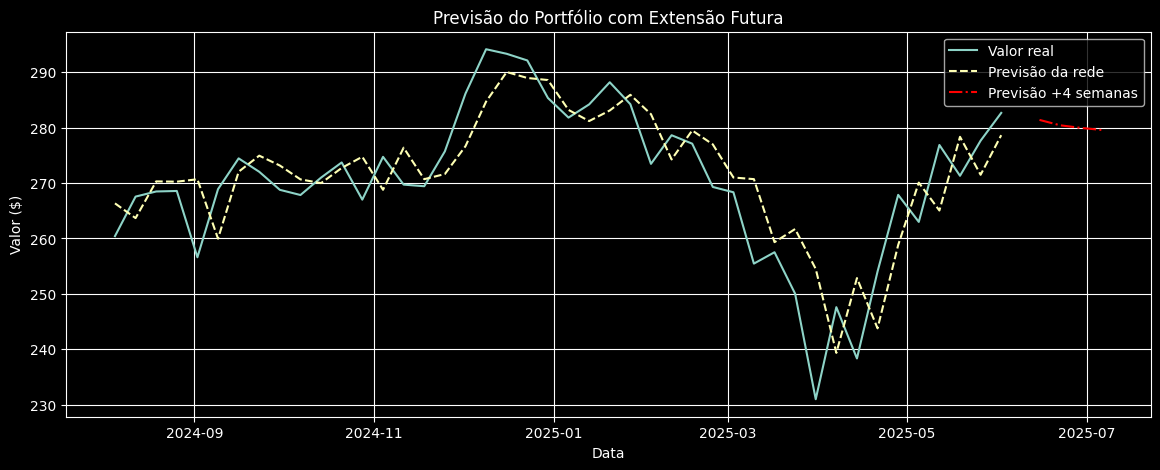

In [793]:
plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
plt.plot(df.index[-len(y_test_real):], y_test_real, label='Valor real')
plt.plot(df.index[-len(predictions_real):], predictions_real, label='Previsão da rede', linestyle='--')
plt.plot(pd.date_range(df.index[-1], periods=FUTURE_STEPS+1, freq='W')[1:], future_predictions_real, label=f'Previsão +{FUTURE_STEPS} semanas', linestyle='-.', color="red")
plt.title('Previsão do Portfólio com Extensão Futura')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()

In [818]:
threshold = 0.015  # 1.5% de variação para decidir compra/venda

index_max = np.argmax(y_test_real)
index_min = np.argmin(y_test_real)

valor_max_real = y_test_real[index_max]
valor_max_previsto = predictions_real[index_max]
data_max = dates[index_max]

valor_min_real = y_test_real[index_min]
valor_min_previsto = predictions_real[index_min]
data_min = dates[index_min]

print(f"📈 Ação mais cara (Portfólio - {' e '.join(TICKERS)}):")
print(f"Data: {data_max.strftime('%Y-%m-%d')}")
print(f"Valor real   : ${valor_max_real:.2f}")
print(f"Valor previsto: ${valor_max_previsto:.2f}\n")

print(f"📉 Ação mais barata (Portfólio - {' e '.join(TICKERS)}):")
print(f"Data: {data_min.strftime('%Y-%m-%d')}")
print(f"Valor real   : ${valor_min_real:.2f}")
print(f"Valor previsto: ${valor_min_previsto:.2f}\n")

decisoes = []
for i in range(len(predictions_real) - 1):
    atual = predictions_real[i]
    futuro = predictions_real[i + 1]
    delta = (futuro - atual) / atual

    if i == 0:
        delta = 0
        decisao = "⚪️ Esperar"
    else:
      if delta > threshold:
          decisao = "🟢 Comprar"
      elif delta < -threshold:
          decisao = "🔴 Vender"
      else:
          decisao = "⚪️ Esperar"

    decisoes.append((dates[i].strftime('%Y-%m-%d'), atual, delta * 100, decisao))

# Mostrar as decisões
print(f"💰 De Acordo com o modelo de Previsão:\n")
print(f"{'Data':<12} {'Valor Atual':<14} {'Δ%':<8} {'Decisão'}")
for data, atual, delta, decisao in decisoes:
    print(f"{data:<12} ${atual:<13.2f} {delta:>+6.2f}%   {decisao}")

capital_inicial = 1000.0
dinheiro = capital_inicial
acoes = 0

for i, (_, atual, _, decisao) in enumerate(decisoes):
    if decisao == "🟢 Comprar" and dinheiro >= atual:
        dinheiro -= atual
        acoes += 1
        # print(f"\n🟢 Compra em {dates[i].strftime('%Y-%m-%d')}: 1 ação a ${atual:.2f}")
    elif decisao == "🔴 Vender" and acoes > 0:
        dinheiro += atual
        acoes -= 1
        # print(f"\n🔴 Venda em {dates[i].strftime('%Y-%m-%d')}: 1 ação a ${atual:.2f}")

# Valor final considerando o último preço como valor de venda das ações restantes
preco_final = predictions_real[-1]
valor_final = dinheiro + acoes * preco_final
lucro = valor_final - capital_inicial

print("\n📊 Resultados finais da simulação:")
print(f"Dinheiro restante (Não investido): ${dinheiro:.2f}")
print(f"Ações restantes: {acoes}")
print(f"Preço final da ação: ${preco_final:.2f}")
print(f"Valor final da carteira: ${valor_final:.2f}")
print(f"Lucro total: ${lucro:.2f} - {(lucro/capital_inicial)*100:.2f}%")



📈 Ação mais cara (Portfólio - AAPL e MSFT e GOOGL):
Data: 2024-12-09
Valor real   : $294.16
Valor previsto: $284.70

📉 Ação mais barata (Portfólio - AAPL e MSFT e GOOGL):
Data: 2025-03-31
Valor real   : $230.97
Valor previsto: $254.49

💰 De Acordo com o modelo de Previsão:

Data         Valor Atual    Δ%       Decisão
2024-08-05   $266.33         +0.00%   ⚪️ Esperar
2024-08-12   $263.67         +2.51%   🟢 Comprar
2024-08-19   $270.30         -0.02%   ⚪️ Esperar
2024-08-26   $270.25         +0.16%   ⚪️ Esperar
2024-09-02   $270.68         -3.96%   🔴 Vender
2024-09-09   $259.96         +4.65%   🟢 Comprar
2024-09-16   $272.04         +1.07%   ⚪️ Esperar
2024-09-23   $274.94         -0.65%   ⚪️ Esperar
2024-09-30   $273.16         -0.92%   ⚪️ Esperar
2024-10-07   $270.66         -0.25%   ⚪️ Esperar
2024-10-14   $269.99         +1.01%   ⚪️ Esperar
2024-10-21   $272.72         +0.74%   ⚪️ Esperar
2024-10-28   $274.74         -2.17%   🔴 Vender
2024-11-04   $268.78         +2.83%   🟢 Comprar
2

####Esse gráfico mostra a performance do modelo LSTM ao longo dos **3 anos**, e não só no conjunto de teste.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


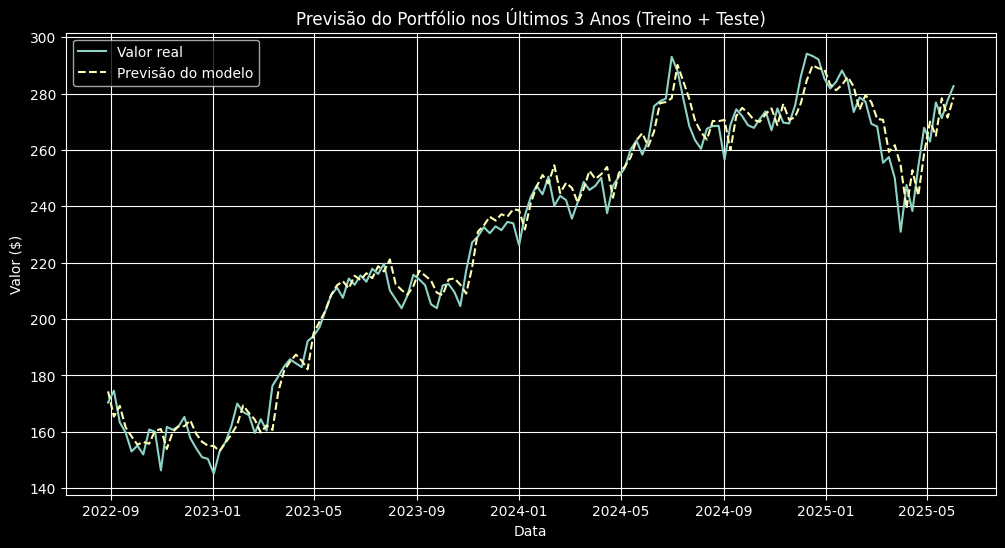

In [774]:
all_predictions = model.predict(X).flatten() # Passa todas as janelas de entrada (X) para o modelo LSTM e depois  transforma um array 2D (shape: (n, 1)) para 1D,
all_predictions_real = all_predictions * std + mean
all_y_real = y * std + mean

all_dates = df.index[WINDOW_SIZE:]  # compensar janela deslizante

# Plotar previsões dos 3 anos

plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
plt.plot(all_dates, all_y_real, label='Valor real')
plt.plot(all_dates, all_predictions_real, label='Previsão do modelo', linestyle='--')
plt.title('Previsão do Portfólio nos Últimos 3 Anos (Treino + Teste)')
plt.xlabel('Data')
plt.ylabel('Valor ($)')
plt.legend()
plt.grid(True)
plt.show()

**Visualização do Loss**

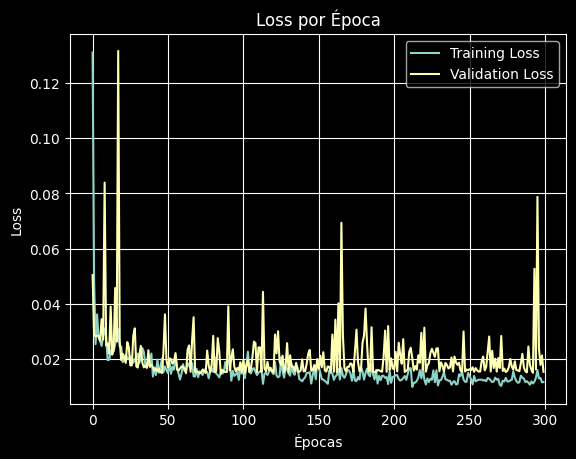

In [775]:
if history:
    loss_data = history.history
elif os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, "r") as f:
        loss_data = json.load(f)
else:
    loss_data = None

if loss_data:
    plt.plot(loss_data['loss'], label='Training Loss')
    plt.plot(loss_data['val_loss'], label='Validation Loss')
    plt.title('Loss por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Nenhum histórico de loss encontrado.")

**Inicializar PCA**

In [776]:
scaler = StandardScaler()
if 'Portfolio' in df.columns:
  df = df.drop("Portfolio",axis=1)
scaled_df = scaler.fit_transform(df)

pca = PCA()
pca.fit(scaled_df)
explained_variance = pca.explained_variance_ratio_ # Variância explicada por componente

**Componentes principais (pesos das ações)**

In [777]:
components = pca.components_
pca_df = pd.DataFrame(components.T,
                      columns=[f'PC{i+1}' for i in range(len(components))],
                      index=df.columns)

**Mostrar a contribuição de cada ação no 1ª componente principal**

In [778]:
print("Contribuição de cada ação no 1º componente principal (PC1):")
print(pca_df['PC1'].sort_values(ascending=False))

Contribuição de cada ação no 1º componente principal (PC1):
GOOGL    0.585721
MSFT     0.576985
AAPL     0.569227
Name: PC1, dtype: float64


**Mostrar a contribuição de cada ação no 2ª componente principal**

In [779]:
print("Contribuição de cada ação no 2º componente principal (PC2):")
if 'PC2' in pca_df.columns:
  print(pca_df['PC2'].sort_values(ascending=False))

Contribuição de cada ação no 2º componente principal (PC2):
AAPL     0.787028
GOOGL   -0.185170
MSFT    -0.588472
Name: PC2, dtype: float64


In [780]:
# Criação de dataframe com os loadings das componentes
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df.columns))], index=df.columns)

# Função de interpretação automática
def interpretar_pca(loadings):
    analises = []

    # PC1: variação principal
    pc1_abs = loadings['PC1'].abs().sort_values(ascending=False)
    mais_influente = pc1_abs.index[0]
    menos_influente = pc1_abs.index[-1]

    analises.append(f"💡 Análise PC1\n\n⏩ O componente principal 1 (PC1) representa a direção de maior variância dos dados, ou seja, a combinação linear que mais resume a variação dos preços das ações.\n\n🔀 {mais_influente} é o ativo que mais influencia, enquanto {menos_influente} interfere menos.")

    # PC2: relação de oposição
    if 'PC2' in loadings.columns:
        pc2 = loadings['PC2']
        positivos = pc2[pc2 > 0].sort_values(ascending=False)
        negativos = pc2[pc2 < 0].sort_values()

        if not positivos.empty and not negativos.empty:
            analises.append(
                f"\n💡 Análise PC2\n\n"
                f"⏩ {positivos.index[0]} = {positivos.iloc[0]:.3f}: contribui positivamente para PC2.\n\n"
                f"⏩ {' e '.join(negativos.index)} negativos: vão na direção oposta de {positivos.index[0]} neste componente.\n\n"
                f"🔁 Isso sugere que quando {positivos.index[0]} se desvia da média geral, "
                f"{' e '.join(negativos.index)} tendem a ir na direção contrária."
            )

    return "\n\n".join(analises)

print(interpretar_pca(loadings))

💡 Análise PC1

⏩ O componente principal 1 (PC1) representa a direção de maior variância dos dados, ou seja, a combinação linear que mais resume a variação dos preços das ações.

🔀 GOOGL é o ativo que mais influencia, enquanto AAPL interfere menos.


💡 Análise PC2

⏩ AAPL = 0.787: contribui positivamente para PC2.

⏩ MSFT e GOOGL negativos: vão na direção oposta de AAPL neste componente.

🔁 Isso sugere que quando AAPL se desvia da média geral, MSFT e GOOGL tendem a ir na direção contrária.


In [781]:
# plt.figure(figsize=(10, 5))
# plt.style.use('dark_background')
# plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
# plt.title('Variância Explicada Acumulada pelo PCA')
# plt.xlabel('Número de Componentes')
# plt.ylabel('Variância Acumulada')
# plt.grid(False)
# plt.show()

In [782]:
n_pontos = 6
future_weaks = 4

resultados = {}

X = np.arange(n_pontos).reshape(-1, 1)
future_x = np.array([[n_pontos + future_weaks]])

resultados = {}

for ticker in TICKERS:
    y = df[ticker].tail(n_pontos).values
    poly_feat = PolynomialFeatures(degree=2)
    X_poly = poly_feat.fit_transform(X)

    model = LinearRegression().fit(X_poly, y)
    future_poly = poly_feat.transform(future_x)
    estimativa = model.predict(future_poly)[0]

    resultados[ticker] = {
        "preço_atual": y[-1],
        "estimado_futuro": estimativa,
        "crescimento_%": round(100 * (estimativa - y[-1]) / y[-1],2)
    }

In [783]:
resultados_df = pd.DataFrame(resultados).T.sort_values(by='crescimento_%', ascending=False)
print("Previsão via Regressão Polinomial de Grau 2:\n")
print(resultados_df)

Previsão via Regressão Polinomial de Grau 2:

       preço_atual  estimado_futuro  crescimento_%
GOOGL   173.679993       213.388508          22.86
MSFT    470.380005       514.318490           9.34
AAPL    203.919998       219.321280           7.55


In [784]:
melhor = resultados_df.iloc[0]
ticker = melhor.name

def interpretar(crescimento):
    if crescimento > 5:
        return "📈 Ótima valorização"
    elif crescimento > 0:
        return "🔼 Leve valorização"
    elif crescimento > -5:
        return "⚖️ Estável, sem crescimento"
    else:
        return "🔻 Forte queda prevista"

resultados_df['Interpretação'] = resultados_df['crescimento_%'].apply(interpretar)

if melhor["crescimento_%"] > 5:
    print(f"\n💡 A ação mais promissora é {ticker}, com estimativa de valorização de {melhor['crescimento_%']:.2f}%.")
    print("📈 Pode ser vantajoso investir e considerar pegar empréstimos moderados para potencializar o ganho.")
elif melhor["crescimento_%"] > 0:
    print(f"\n✅ {ticker} é a ação com maior tendência de valorização ({melhor['crescimento_%']:.2f}%), mas talvez não justifique pegar empréstimos.")
else:
    print(f"\n⚠️ Nenhuma ação mostra tendência clara de valorização. Não é recomendável pegar empréstimos agora.")

print("Previsão via Regressão Polinomial de Grau 2:\n")
print(resultados_df[['crescimento_%', 'Interpretação']])



💡 A ação mais promissora é GOOGL, com estimativa de valorização de 22.86%.
📈 Pode ser vantajoso investir e considerar pegar empréstimos moderados para potencializar o ganho.
Previsão via Regressão Polinomial de Grau 2:

       crescimento_%        Interpretação
GOOGL          22.86  📈 Ótima valorização
MSFT            9.34  📈 Ótima valorização
AAPL            7.55  📈 Ótima valorização


In [785]:
# # Calcular retornos dos ativos
# returns = df.pct_change().dropna()

# # Estatísticas básicas
# mean_returns = returns.mean()
# cov_matrix = returns.cov()
# TICKERS = df.columns.tolist()
# risk_free_rate = 0.01

# # Simula múltiplos portfólios
# def simulate_portfolios(num_portfolios=5000):
#     results = {'returns': [], 'volatility': [], 'sharpe': [], 'weights': []}
#     for _ in range(num_portfolios):
#         weights = np.random.random(len(TICKERS))
#         weights /= np.sum(weights)

#         port_return = np.dot(weights, mean_returns)
#         port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#         sharpe_ratio = (port_return - risk_free_rate) / port_vol

#         results['returns'].append(port_return)
#         results['volatility'].append(port_vol)
#         results['sharpe'].append(sharpe_ratio)
#         results['weights'].append(weights)

#     return pd.DataFrame(results)

# # Executa simulação
# portfolios = simulate_portfolios()

# # Encontra portfólio ótimo (maior Sharpe)
# best = portfolios.loc[portfolios['sharpe'].idxmax()]

# weights = best['weights']

# # Análise dinâmica
# def analise_dinamica_markowitz(tickers, weights, retorno, risco, sharpe):
#     maior = tickers[np.argmax(weights)]
#     menor = tickers[np.argmin(weights)]
#     top_ativos = sorted(zip(tickers, weights), key=lambda x: -x[1])[:2]

#     texto = f"""💼 **Análise do Portfólio Ótimo (Markowitz)**

# 📈 O portfólio de melhor desempenho apresenta um **retorno esperado de {retorno:.2%}** com uma **volatilidade de {risco:.2%}**, resultando em um **Índice de Sharpe de {sharpe:.2f}**.

# 🏆 A maior alocação foi para **{maior} ({weights[np.argmax(weights)]:.2%})**, enquanto **{menor} ({weights[np.argmin(weights)]:.2%})** teve o menor peso na composição.

# 📊 Composição dominante:
# - {top_ativos[0][0]}: {top_ativos[0][1]:.2%}
# - {top_ativos[1][0]}: {top_ativos[1][1]:.2%}

# ✅ Essa distribuição busca **maximizar o retorno ajustado ao risco**, conforme os dados históricos de retornos semanais.\n"""

#     return texto

# # Exibe análise
# if len(TICKERS) > 1:

#   print(analise_dinamica_markowitz(TICKERS, weights, best['returns'], best['volatility'], best['sharpe']))

#   max_sharpe = portfolios.loc[portfolios['sharpe'].idxmax()]
#   min_vol = portfolios.loc[portfolios['volatility'].idxmin()]

#   # Gráfico da fronteira eficiente
#   plt.figure(figsize=(10, 6))
#   plt.scatter(portfolios['volatility'], portfolios['returns'], c=portfolios['sharpe'], cmap='viridis', alpha=0.5)
#   plt.colorbar(label='Índice de Sharpe')
#   plt.scatter(max_sharpe['volatility'], max_sharpe['returns'], c='red', marker='*', s=200, label='Máx. Sharpe')
#   plt.scatter(min_vol['volatility'], min_vol['returns'], c='blue', marker='*', s=200, label='Mín. Risco')
#   plt.xlabel('Volatilidade (Risco)')
#   plt.ylabel('Retorno Esperado')
#   plt.title('Fronteira Eficiente - Teoria Moderna do Portfólio')
#   plt.legend()
#   plt.grid(True)
#   plt.show()


In [786]:
# # ============
# # Análise com Pesos Reais
# # ============

# print(best['weights'][0] if len(TICKERS) == 1 else best['weights']
# # Define os pesos desejados aqui (ordem deve corresponder a TICKERS)
# # Exemplo: 50% AAPL, 30% MSFT, 20% GOOGL, nesse caso, quero provar a realidade dos pesos

# if len(TICKERS) > 1:
#   pesos_reais = np.array([best['weights'][0], best['weights'][1], best['weights'][2]]) #Usando os pesos antes gerados aleatoriamente

#   # Verifica se somam 1
#   if not np.isclose(np.sum(pesos_reais), 1.0):
#       raise ValueError("Os pesos devem somar 1. Corrija os valores em 'pesos_reais'.")

#   # Calcula retorno, risco e Sharpe
#   retorno_real = np.dot(pesos_reais, mean_returns)
#   volatilidade_real = np.sqrt(np.dot(pesos_reais.T, np.dot(cov_matrix, pesos_reais)))
#   sharpe_real = (retorno_real - risk_free_rate) / volatilidade_real

#   # Análise com pesos reais
#   print("\n📌 Análise do Portfólio com Pesos Reais:")
#   print(analise_dinamica_markowitz(TICKERS, pesos_reais, retorno_real, volatilidade_real, sharpe_real))

#   # Gráfico da fronteira eficiente
#   plt.figure(figsize=(10, 6))
#   plt.scatter(portfolios['volatility'], portfolios['returns'], c=portfolios['sharpe'], cmap='viridis', alpha=0.5)
#   plt.colorbar(label='Índice de Sharpe')
#   plt.scatter(max_sharpe['volatility'], max_sharpe['returns'], c='red', marker='*', s=200, label='Máx. Sharpe')
#   plt.scatter(min_vol['volatility'], min_vol['returns'], c='blue', marker='*', s=200, label='Mín. Risco')
#   plt.scatter(volatilidade_real, retorno_real, c='black', marker='x', s=200, label='Portfólio')
#   plt.xlabel('Volatilidade (Risco)')
#   plt.ylabel('Retorno Esperado')
#   plt.title('Fronteira Eficiente com Portfólio Real')
#   plt.legend()
#   plt.grid(True)
#   plt.show()
